In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [13]:
import numpy as np
import pandas as pd
import os
import pickle

from sklearn import preprocessing

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle

## Init

In [4]:
hg38_chro_size = {'1': 248956422, '2':242193529, '3':198295559, '4':190214555, '5':181538259, '6':170805979,
                  '7': 159345973, '8':145138636, '9':138394717, '10':133797422, '11':135086622,
                  '12': 133275309, '13':114364328, '14':107043718, '15':101991189, '16':90338345,
                  '17':83257441, '18': 80373285, '19': 58617616, '20':64444167, '21':46709983,
                  '22':50818468, '23':156040895, '24':57227415}

In [5]:
bin_size = 1000000

In [6]:
hg38_chro = pd.DataFrame.from_dict(hg38_chro_size, orient='index', columns=['size'])
    

hg38_chro = hg38_chro.assign(bin= np.ceil(hg38_chro['size']/bin_size))

hg38_chro.index = hg38_chro.index.astype(int)

hg38_chro['tick'] = hg38_chro.apply(lambda x: 
                                   hg38_chro.loc[:x.name-1, 'bin'].sum() + 
                                   np.ceil(x['bin']/2), 
                               axis=1)  

hg38_chro['name'] = 'chr' + hg38_chro.index.astype(str)

hg38_chro['start'] = hg38_chro.apply(lambda x: 
                                   hg38_chro.loc[:x.name-1, 'bin'].sum(), 
                               axis=1)  

hg38_chro['end'] = hg38_chro.apply(lambda x: 
                                   hg38_chro.loc[:x.name, 'bin'].sum()-1, 
                               axis=1) 

## Prepare data

In [3]:
with open('/Users/bogao/DataFiles/new landscape/data/reduced_gene_mat.pkl', 'rb') as fi:
    data = pickle.load(fi)
with open('/Users/bogao/DataFiles/new landscape/files/all_bands_subtype_label.pkl', 'rb') as fi:
    labels = pickle.load(fi)

In [7]:
amp_genes = pd.read_csv('/Users/bogao/DataFiles/Data/genome/reduced_high_amp_genes.tsv', sep='\t')
del_genes = pd.read_csv('/Users/bogao/DataFiles/Data/genome/reduced_high_del_genes.tsv', sep='\t')

In [8]:
amp_genes

gene_id    name  chr     start       end    symbol      band
0    ENSG00000157911  p36.32    1   2403964   2413797     PEX10   1p36.32
1    ENSG00000157873  p36.32    1   2555639   2565382  TNFRSF14   1p36.32
2    ENSG00000158109  p36.32    1   3625015   3630127    TPRG1L   1p36.32
3    ENSG00000130764  p36.32    1   3778559   3796498    LRRC47   1p36.32
4    ENSG00000169598  p36.32    1   3857267   3885429      DFFB   1p36.32
..               ...     ...  ...       ...       ...       ...       ...
745  ENSG00000178026  q11.23   22  24585620  24593208   LRRC75B  22q11.23
746  ENSG00000184571  q11.23   22  24719034  24774720    PIWIL3  22q11.23
747  ENSG00000206069  q11.23   22  24934954  24946695   TMEM211  22q11.23
748  ENSG00000197077  q11.23   22  24952730  25197448  KIAA1671  22q11.23
749  ENSG00000244752  q11.23   22  25212564  25231870    CRYBB2  22q11.23

[750 rows x 7 columns]

In [9]:
disease_names = list(np.unique(labels['disease']))
disease_names.remove('NA')

In [14]:
 preprocessing.minmax_scale(np.abs( np.sum(data[labels['disease'] == disease_names[0]],axis=0) ))

array([0.16324206, 0.16324206, 0.21243108, 0.20233621, 0.2018008 ,
       0.18235633, 0.19412377, 0.19412377, 0.18224524, 0.18570303,
       0.18570303, 0.18242808, 0.18517379, 0.18517379, 0.18833687,
       0.18680008, 0.18680008, 0.18680008, 0.18685948, 0.18685948,
       0.19203151, 0.19203151, 0.19203151, 0.19203151, 0.19128113,
       0.19333146, 0.19333146, 0.21733694, 0.21002405, 0.21002405,
       0.18956353, 0.18956353, 0.19182321, 0.17603865, 0.17566449,
       0.19755842, 0.19755842, 0.19882288, 0.19882288, 0.19885528,
       0.19885528, 0.1983569 , 0.19470393, 0.19470393, 0.19470393,
       0.19634611, 0.1961304 , 0.19514877, 0.19593984, 0.19556799,
       0.19510664, 0.1950673 , 0.18844102, 0.18686488, 0.18627778,
       0.18646063, 0.18646063, 0.18490532, 0.19185956, 0.1782235 ,
       0.17284008, 0.17070616, 0.17089316, 0.16916088, 0.17338167,
       0.17338167, 0.17350125, 0.17030267, 0.16985676, 0.1688276 ,
       0.1688276 , 0.16118297, 0.16304585, 0.1630893 , 0.16431

In [15]:
amps = []
dels = []
for disease in disease_names:
    scaled_gene_values =  preprocessing.minmax_scale(np.abs( np.sum(data[labels['disease'] == disease],axis=0) ))
    amps.append(amp_genes.assign(cnv_scaled = scaled_gene_values[:750]))
    dels.append(del_genes.assign(cnv_scaled = scaled_gene_values[750:]))

In [16]:
xs = []
ys = []
zs = []
xd = []
yd = []
zd = []
colors = []
cm = plt.get_cmap('Set2')
num_colors = len(cm.colors)
i = 0
for df, y in zip(amps, np.arange(len(amps))):
#     if i >4:
#         break
    df['bin'] = df.apply(lambda x: 
                                   hg38_chro.loc[:x['chr']-1, 'bin'].sum() + 
                                   np.ceil(x['start']/bin_size), 
                               axis=1)     
    data = df.groupby(by='bin').mean()
    
    size = data.shape[0]
    
    xs += data.index.astype(int).tolist()
    ys += [y] * size
    zs += [0] * size

    xd += [0.8] * size 
    yd += [0.2] * size 
    zd += data['cnv_scaled'].tolist()
    
    colors += [cm.colors[i % num_colors]] * size
    i += 1


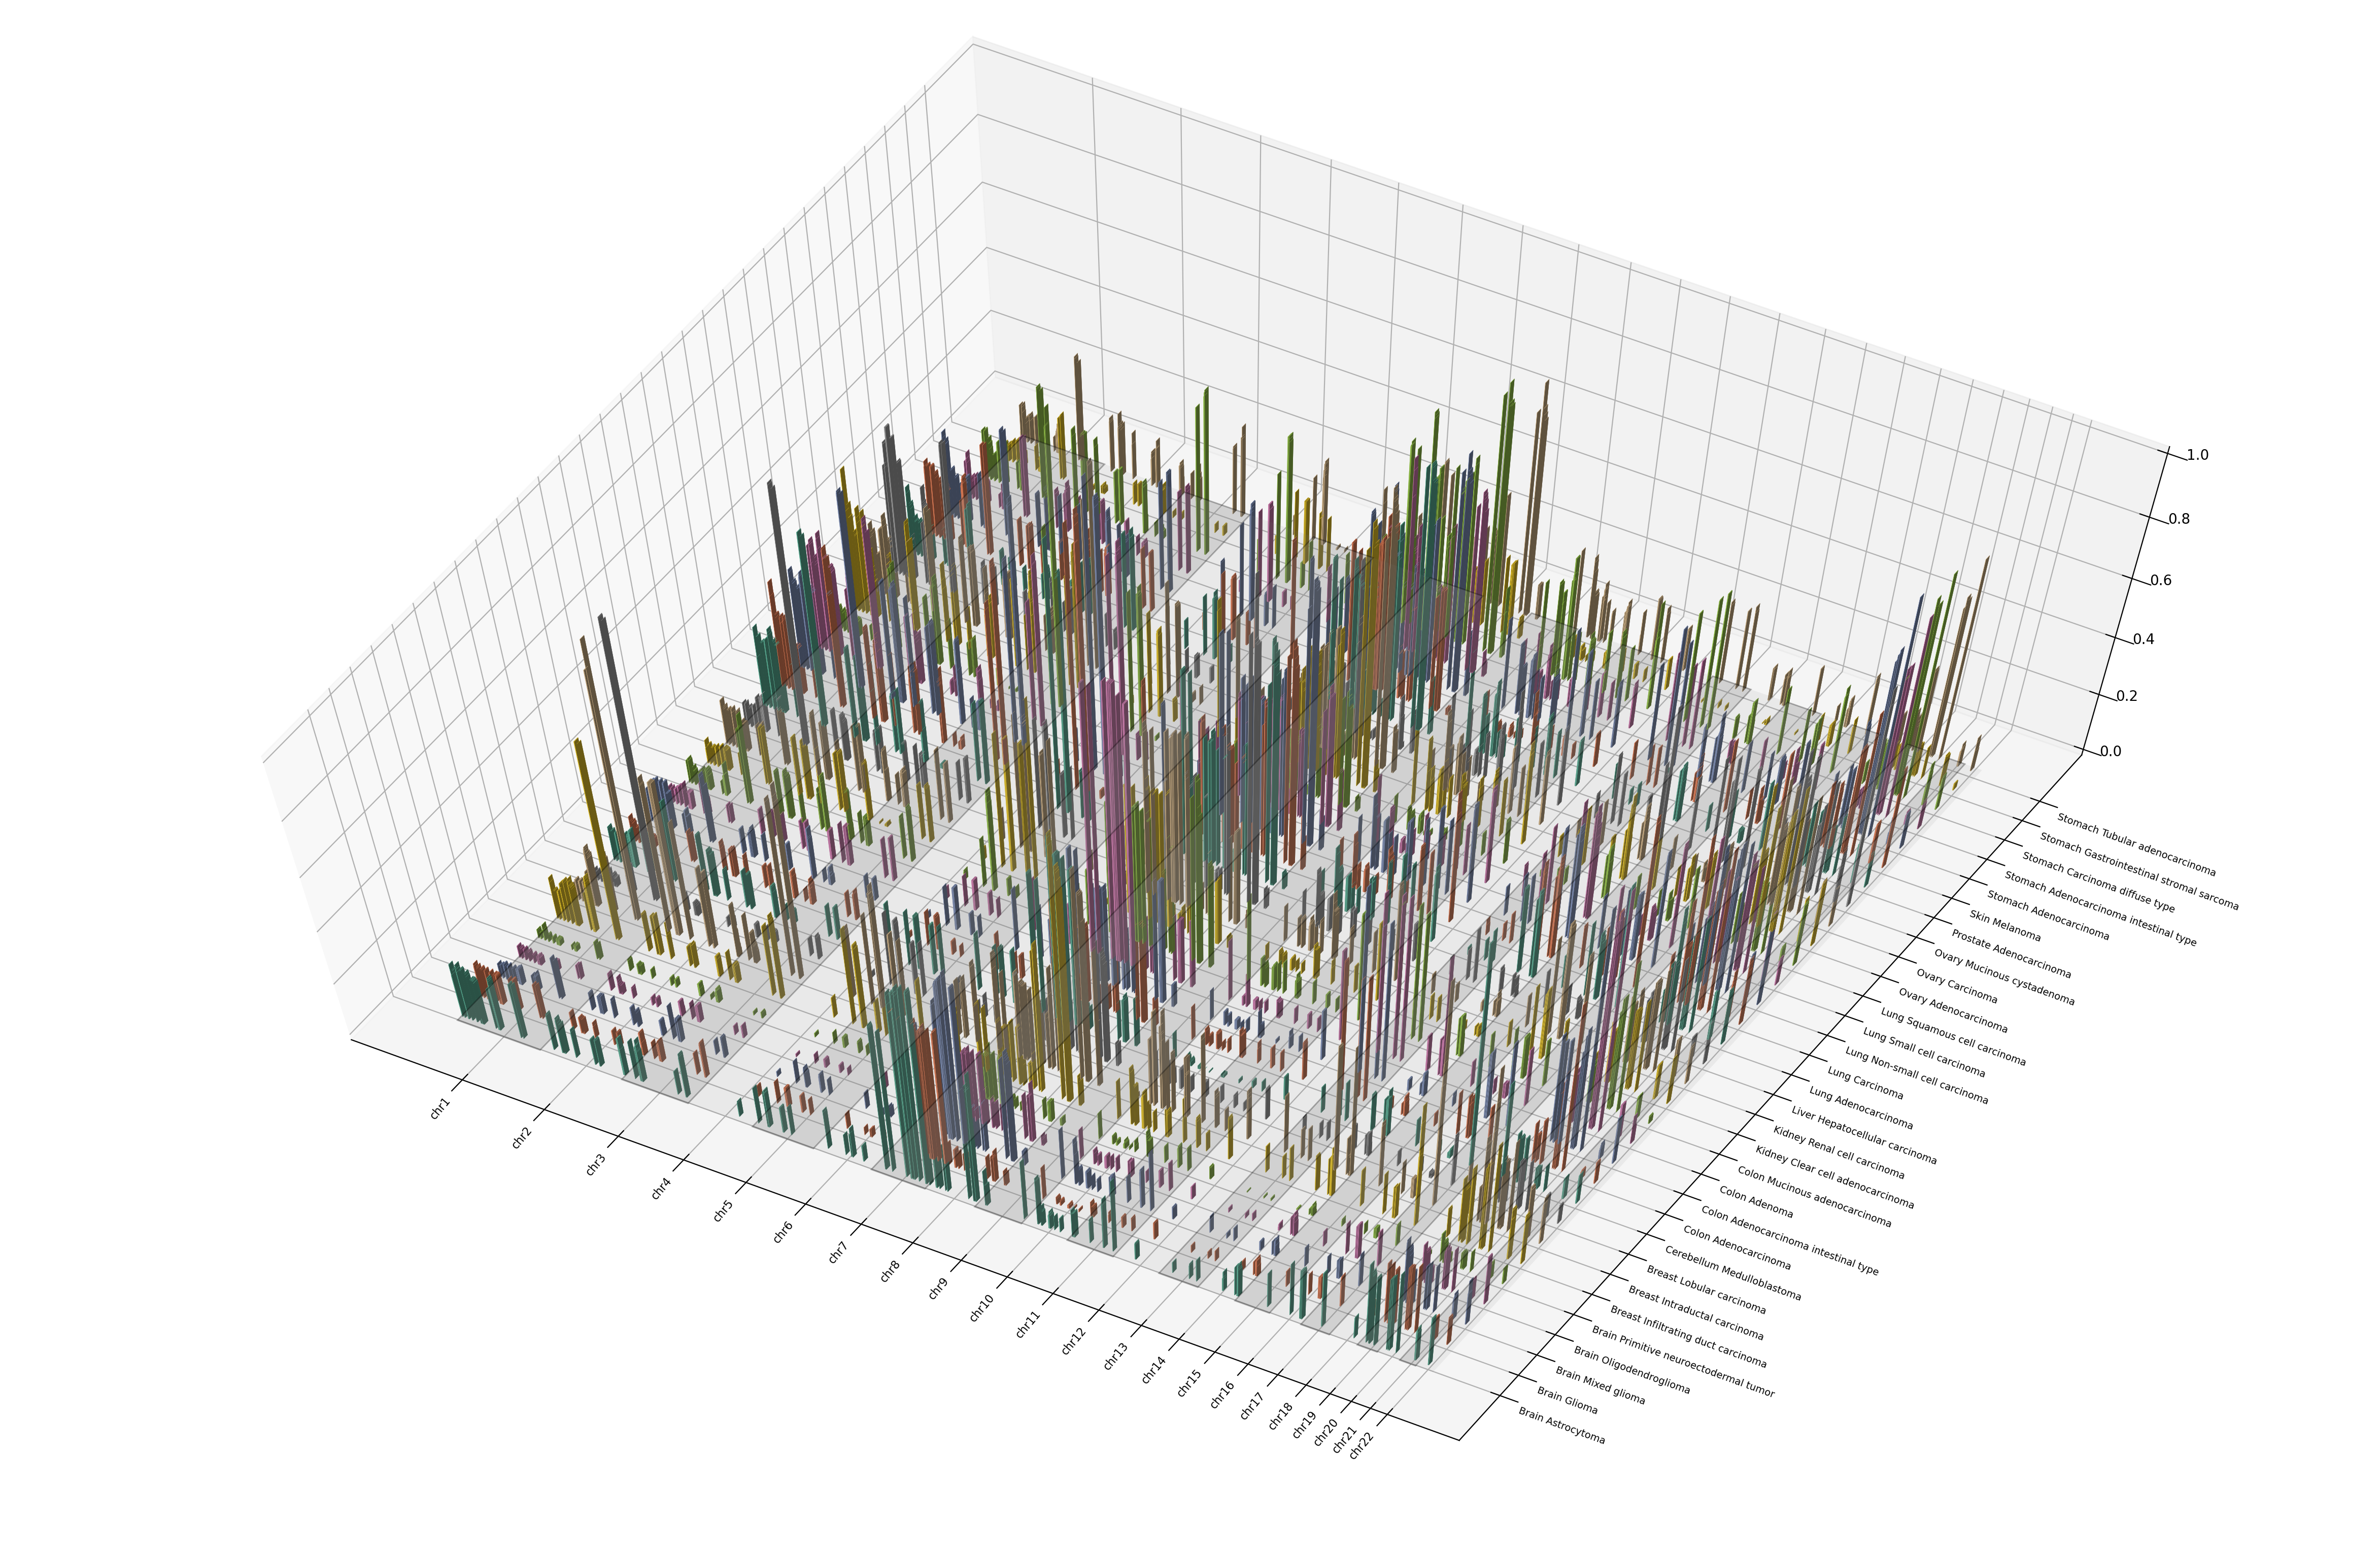

In [18]:
plt.rcParams['figure.dpi'] = 200
fig = plt.figure(figsize=(30,20))

ax = fig.add_subplot(111, projection='3d')


for j in range(1,23):
    if j % 2 == 1:
        p = Rectangle((hg38_chro.loc[j,'start'], -0.2), hg38_chro.loc[j,'bin']-1,i-0.6, fc='grey', alpha=0.3, ec='black')
    else:
        p = Rectangle((hg38_chro.loc[j,'start'], -0.2), hg38_chro.loc[j,'bin']-1,i-0.6, fc='grey', alpha=0.1)
    ax.add_patch(p)
    art3d.pathpatch_2d_to_3d(p, z=0, zdir="z")

ax.bar3d(xs, ys, zs, xd, yd, zd, color=colors)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
ax.w_yaxis.set_ticks(range(i))
ax.w_yaxis.set_ticklabels(disease_names[:i], rotation=-20, fontsize=7,
#                    verticalalignment='bottom',
                   horizontalalignment='left')

ax.w_xaxis.set_ticks(hg38_chro.loc[:22, 'tick'])
ax.w_xaxis.set_ticklabels(hg38_chro.loc[:22, 'name'], rotation=50, fontsize=8,
#                    verticalalignment='bottom',
                   horizontalalignment='right')

ele=ax.elev
ax.view_init(elev=ele+40)